# How to generate histograms using Oracle SQL

This provides and example of how to generate frequency histograms using the Oracle SQL.
Disambiguation: we refer here to computing histograms of table data, rather than histograms of the columns statistics used by the cost based optimizer.

Author and contacts: Luca.Canali@cern.ch

## Setup and prerequisites

This is how you can setup a local Oracle instance for testing using a docker image for oracle-free.  
CERN users can also use accounts on a development database (contact Oracle service at CERN to request one)

**1. run Oracle Free on a container from gvenzl dockerhub repo https://github.com/gvenzl/oci-oracle-free**

Run oracle free on a container from gvenzl dockerhub repo, use docker or podman   
see also https://github.com/gvenzl/oci-oracle-free  
`docker run -d --name mydb1 -e ORACLE_PASSWORD=oracle -p 1521:1521 gvenzl/oracle-free:23.5-slim`

Wait till the DB is started, it will take a few minutes  
check progress with:  
`docker logs -f mydb1`


**2. Install the scott/tiger schema with the emp table in PDB freepdb1:**
```
docker exec -it mydb1 /bin/bash
sed -e s=SCOTT/tiger=SCOTT/tiger@freepdb1= -e s/OFF/ON/ /opt/oracle/product/23ai/dbhomeFree/rdbms/admin/utlsampl.sql > script.sql
sqlplus system/oracle@freepdb1
@script.sql
```


**Notes on the oracledb library:**   
This uses oracledb to connect to oracle, so no need to install the Oracle client for this example.  
Note: oracledb can also work with the oracle client using `oracledb.init_oracle_client()`, see documentation for details.

## Use Oracle from Python with Oracledb
Oracledb is the Python library to connect to Oracle DBs, the next version of cx_Oracle

In [1]:
# connect to Oracle using oracledb
# !pip install oracledb

import oracledb

# To avoid storing connection passwords use getpas or db_config
# import getpass
# db_pass = getpass.getpass()

db_user = 'scott'
db_pass = 'tiger'

db_connect_string = 'localhost:1521/freepdb1'
sqlalchemy_db_connect_string = 'localhost:1521?service_name=freepdb1'

## Create the test table

In [2]:
with oracledb.connect(user=db_user, password=db_pass, dsn=db_connect_string) as ora_conn:

    cursor = ora_conn.cursor()
    
    # use this drop statement if you need to recreate the table
    cursor.execute("drop table if exists data")

    cursor.execute("begin dbms_random.seed(4242); end;")

    cursor.execute("""
        create table data as 
        select dbms_random.value * 100 random_value 
        from dual connect by level <=100
        """)



## Define the query to compute the histogram

In [3]:
table_name = "data" # table or temporary view containing the data
value_col = "random_value" # column name on which to compute the histogram
min = -20  # min: minimum value in the histogram
max = 90   # maximum value in the histogram
bins = 11  # number of histogram buckets to compute
step = (max - min) / bins
        

query = f"""
with bucketized as (
  select width_bucket({value_col}, {min}, {max}, {bins}) as bucket
  from {table_name}
),
hist as (
  select bucket, count(*) as cnt
  from bucketized
  group by bucket
),
buckets as (
  select rownum as bucket from dual connect by level <= {bins}
)
select
    bucket, {min} + (bucket - 1/2) * {step} as value,
    nvl(cnt, 0) as count
from buckets left outer join hist using(bucket)
order by bucket
"""

## Fetch the histogram data into a pandas dataframe

In [4]:
import pandas as pd
from sqlalchemy import create_engine

# create SQLAlchemy engine
engine = create_engine(f"oracle+oracledb://{db_user}:{db_pass}@{sqlalchemy_db_connect_string}")

In [5]:
# query Oracle using ora_conn and put the result into a pandas Dataframe
hist_pandasDF = pd.read_sql(query, engine)

# Decription of the resulting dataframe
#
# BUCKET: the bucket number, range from 1 to bins (included)
# VALUE: midpoint value of the given bucket
# COUNT: number of values in the bucket 

hist_pandasDF

,bucket,value,count
0,1,-15,0
1,2,-5,0
2,3,5,9
3,4,15,7
4,5,25,12
5,6,35,13
6,7,45,7
7,8,55,11
8,9,65,8
9,10,75,13


In [6]:
# Optionally normalize the event count into a frequency
# dividing by the total number of events
 
hist_pandasDF["frequency"] = hist_pandasDF["count"] / sum(hist_pandasDF["count"]) 
              
hist_pandasDF

,bucket,value,count,frequency
0,1,-15,0,0.000000
1,2,-5,0,0.000000
2,3,5,9,0.098901
3,4,15,7,0.076923
4,5,25,12,0.131868
5,6,35,13,0.142857
6,7,45,7,0.076923
7,8,55,11,0.120879
8,9,65,8,0.087912
9,10,75,13,0.142857


## Histogram plotting

The first plot is a histogram with the event counts (number of events per bin).
The second plot is a histogram of the events frequencies (number of events per bin normalized by the sum of the events).


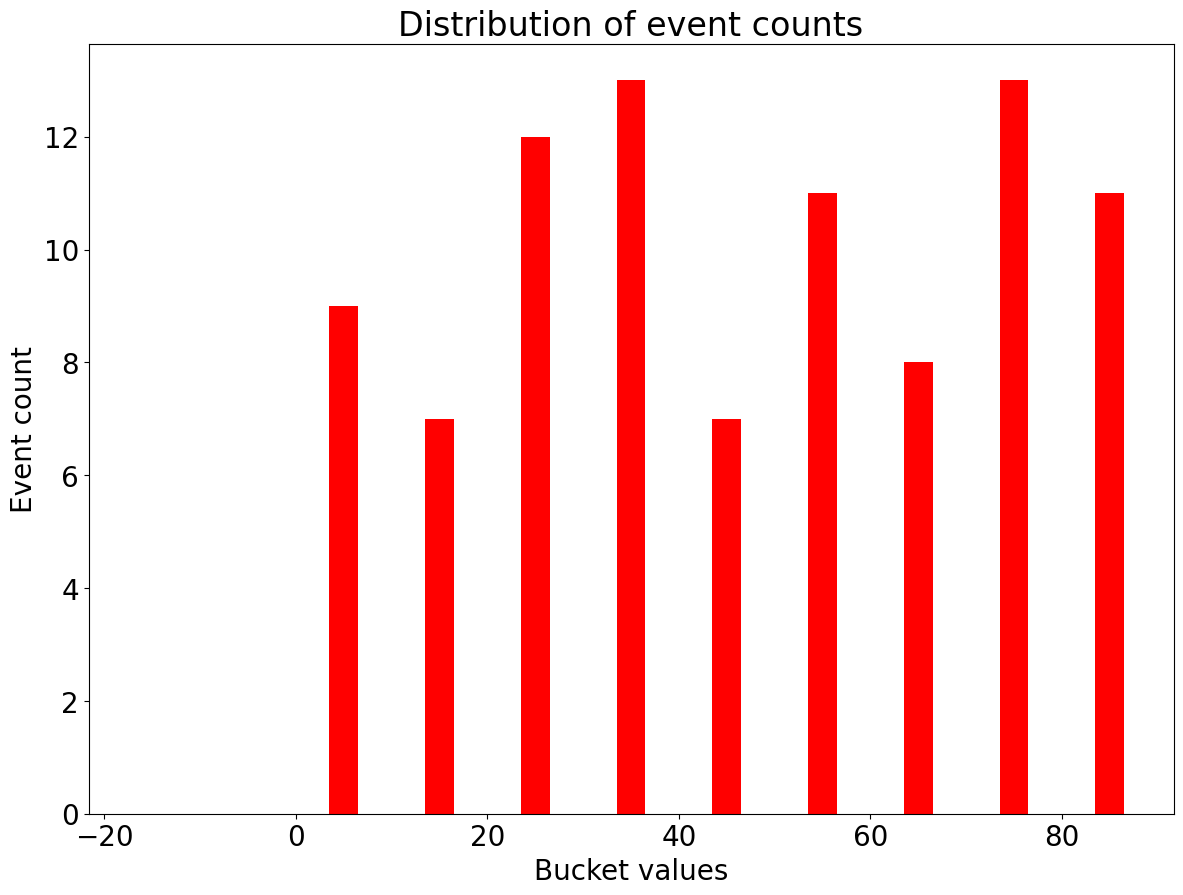

In [7]:
import matplotlib.pyplot as plt 

plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# histogram data
x = hist_pandasDF["value"]
y = hist_pandasDF["count"]

# bar plot
ax.bar(x, y, width = 3.0, color='red')

ax.set_xlabel("Bucket values")
ax.set_ylabel("Event count")
ax.set_title("Distribution of event counts")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.show()

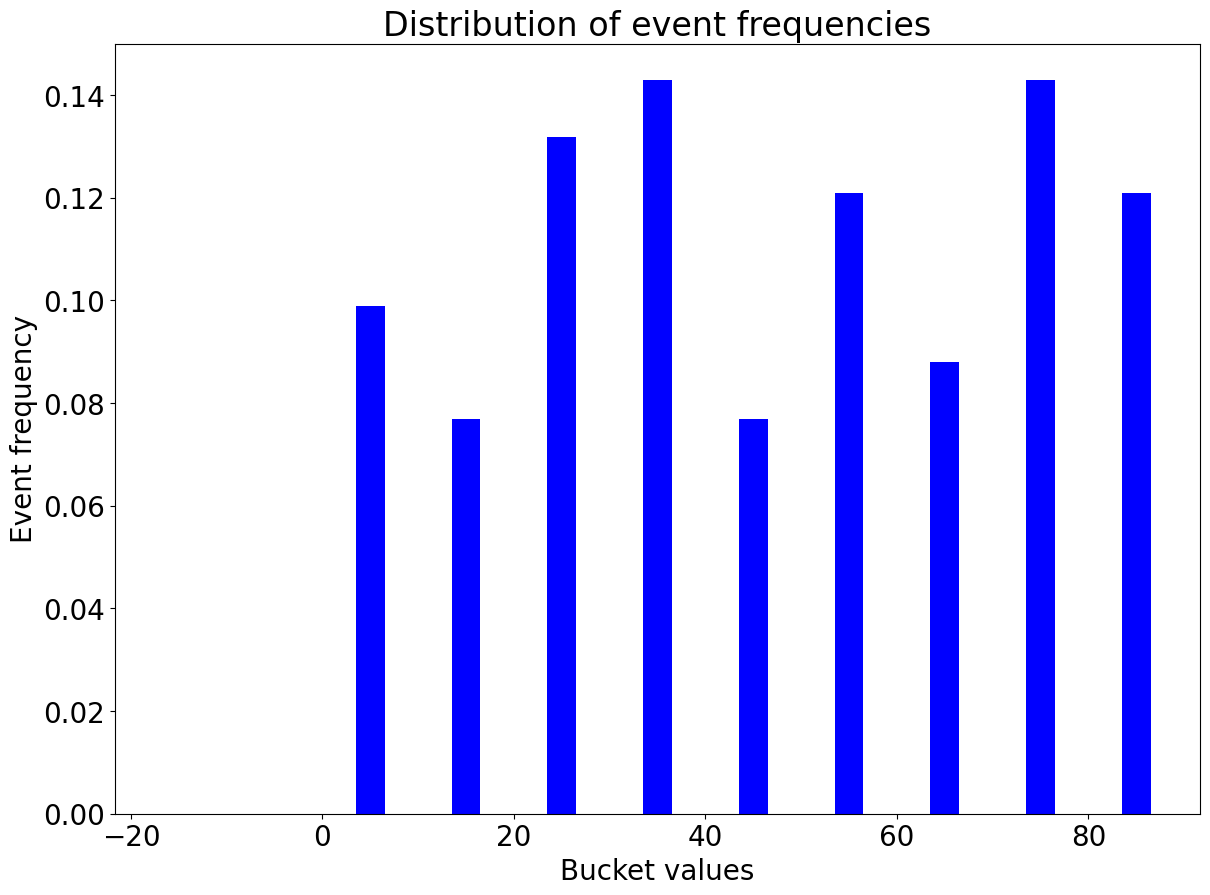

In [8]:
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# histogram data
x = hist_pandasDF["value"]
y = hist_pandasDF["frequency"]

# bar plot
ax.bar(x, y, width = 3.0, color='blue')

ax.set_xlabel("Bucket values")
ax.set_ylabel("Event frequency")
ax.set_title("Distribution of event frequencies")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.show()

